In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pysam
from Bio.Seq import Seq
from Bio import SeqIO
from matplotlib.gridspec import GridSpec
from matplotlib import patches
from scipy.signal import savgol_filter
from fuzzysearch import find_near_matches

In [2]:
matepair_df = pd.read_csv('../KCXZ0001A_export/A_matepairs.csv', index_col=0)
rDNA_45S = list(SeqIO.parse('../templates_refs/rDNAscaffold_45S.fa', format='fasta'))[0].seq

In [3]:
template = SeqIO.parse('references/220416_template.fa', format='fasta')
template = str(list(template)[0].seq)
LacO_seq = 'TGTGGAATTGTGAGCGCTCACAATTCCACA'
LacO_sites = [template.find(LacO_seq), template.rfind(LacO_seq)]
CBh_start = 'gttacataacttacggtaaatggcccgcctg'
GFP_start = 'CGTACGGCCAC'
CBh_site = [template.find(CBh_start), template.find(GFP_start)]

In [4]:
transgene_ref = 'rDNA-flanked_TriCasA5_CBhBsi_GFP_GeFo3'
flank_len = 840
transgene_len = 2246
end = flank_len+transgene_len

# plot coverage

In [5]:
# generate read pileup

pos_list = np.array([], dtype=int)

for i, row in matepair_df.iterrows():
    temp_list = np.array([], dtype=int)
    for x,y in zip([1,1,2,2],[1,2,1,2]):
        if row['read%i_chr%i' % (x,y)] == transgene_ref:
            temp_list = np.hstack([temp_list,np.arange(row['read%i_start%i' % (x,y)],row['read%i_end%i' % (x,y)]+1, dtype=int)])
    pos_list = np.hstack([pos_list,np.unique(temp_list)])

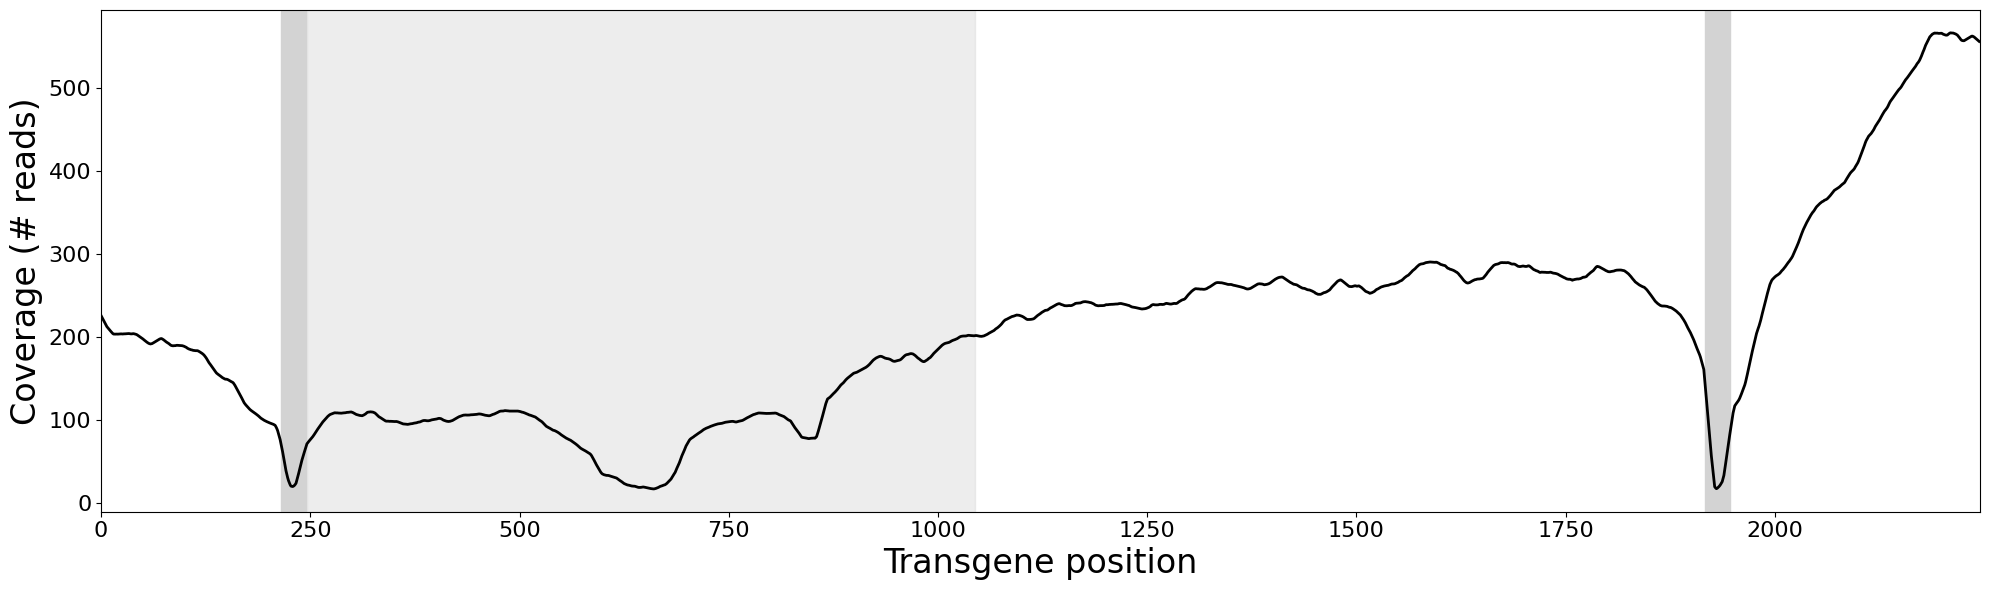

In [6]:
bins = np.arange(flank_len, end+1)
y = plt.hist(pos_list, bins=bins)
plt.close()

fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
ax.plot(range(transgene_len-1), savgol_filter(y[0][:-1],13,1), c='k', lw=2)

ax.set_xlim((0,transgene_len-1))

ax.axvspan(CBh_site[0], CBh_site[1], color='lightgray', alpha=0.4)

ax.axvspan(LacO_sites[0], LacO_sites[0]+len(LacO_seq), color='lightgray')
ax.axvspan(LacO_sites[1], LacO_sites[1]+len(LacO_seq), color='lightgray')

ax.tick_params(labelsize=16)
ax.set_ylabel('Coverage (# reads)', fontsize=24)
ax.set_xlabel('Transgene position', fontsize=24)

fig.tight_layout()
# fig.savefig('plots/transgene_coverage_A.png')
# fig.savefig('plots/transgene_coverage_A.eps')

# assess 3' junctions

In [7]:
def is_rDNA(chrom, coord):
    is_rDNA = chrom in ['rDNA-flanked_TriCasA5_CBhBsi_GFP_GeFo3','NR_145819.1']
    chr13 = chrom == 'chr13' and 5770548 < coord < 9348041
    chr14 = chrom == 'chr14' and 2099537 < coord < 2817811
    chr15 = chrom == 'chr15' and 2506442 < coord < 4707485
    chr21 = chrom == 'chr21' and 3108298 < coord < 5612715
    chr22 = chrom == 'chr22' and 4793794 < coord < 5720650
    is_rDNA = is_rDNA or chr13 or chr14 or chr15 or chr21 or chr22
    return is_rDNA

In [8]:
def get_bestmatch(matches):
    if len(matches) == 0:
        return 0
    elif len(matches) == 1:
        return matches[0]
    else:
        best_match = matches[0]
        for match in matches:
            if match.dist < best_match.dist:
                best_match = match
        return best_match

In [9]:
initiationsites = np.array([], dtype=int)
initiationsites_nodup = np.array([], dtype=int)
C_In = 0
I_P = 0
I_Im = 0
I_In = 0
IVS_list = []
upstream = 'TGTTCGG'
downstream = 'TAGCCAA'
off_target = []
manual_review = {}

for i, row in matepair_df.iterrows():
    CIn_temp = False
    IP_temp = False
    IIm_temp = False
    IIn_temp = False
    initiationsites_temp = []
    temp_IVS = []
    for x in [1,2]:
        ## get reads that cross 3' junction
        if (row['read%i_chr1' % x] == transgene_ref and row['read%i_start1' % x] < (end-5) and (end+5) < row['read%i_end1' % x]) or \
            (row['read%i_chr2' % x] == transgene_ref and row['read%i_start2' % x] < (end-5) and (end+5) < row['read%i_end2' % x]):
            # identify known upstream and downstream sequence to extract intervening sequence
            upstream_match = get_bestmatch(find_near_matches(upstream, row['read%i_seq' % x], max_l_dist=1))
            downstream_match = get_bestmatch(find_near_matches(downstream, row['read%i_seq' % x], max_l_dist=1))
            if upstream_match and downstream_match:
                temp_IVS.append(row['read%i_seq' % x][upstream_match.end-1:downstream_match.start+4])
                initiationsites_temp.append(end)
            elif downstream_match and downstream_match.start<11:
                upstream_match = find_near_matches('GAA', row['read%i_seq' % x][:downstream_match.start], max_l_dist=1)
                temp_IVS.append(row['read%i_seq' % x][upstream_match[0].start:downstream_match.start+4])
                initiationsites_temp.append(end)
            else:
                manual_review[i] = temp_IVS
        ## get right-clipped reads
        elif row['read%i_chr1' % x] == transgene_ref and row['read%i_clipstatus1' % x] == '3clipped' and \
        row['read%i_end1' % x]>(flank_len+10) and row['read%i_start1' % x]<(end-10):
            if row['read%i_end1' % x] == end: # proper initiation
                if row['read%i_chr2' % x] != '-1':
                    IP_temp = True
            elif np.abs(row['read%i_end1' % x] - end) < 4: # improper initiation
                if row['read%i_chr2' % x] != '-1':
                    IIm_temp = True
            else: # internal initiation
                if (row['read%i_chr2' % x] == transgene_ref and np.abs(row['read%i_start2' % x]-end)<5) or \
                   (row['read%i_chr2' % x] == 'NR_145819.1' and np.abs(row['read%i_start2' % x]-11698)<5):
                    CIn_temp = True
                    initiationsites_temp.append(row['read%i_end1' % x])
                elif is_rDNA(row['read%i_chr2' % x], row['read%i_start2' % x]):
                    if row['read%i_chr2' % x] == transgene_ref and row['read%i_start2' % x] < end:
                        pass
                    else:
                        IIn_temp = True
                elif row['read%i_chr2' % x] != '-1':
                    off_target.append(row['read_ID'])
    C_In += CIn_temp
    I_P += IP_temp
    I_Im += IIm_temp
    I_In += IIn_temp
    
    temp_IVS = np.unique(temp_IVS)
    if len(temp_IVS)>1:
        manual_review[row['read_ID']] = temp_IVS
    else:
        IVS_list = np.hstack([IVS_list, temp_IVS])
    
    initiationsites = np.hstack([initiationsites,initiationsites_temp])
    initiationsites_nodup = np.hstack([initiationsites_nodup,np.unique(initiationsites_temp)])

In [10]:
# manual assessment of categories
C_P = Counter(IVS_list)['GAAAATAGC']+Counter(IVS_list)['GAAAATGGC']+Counter(IVS_list)['GAAAATCGC']
C_Im = Counter(IVS_list)['GAAAGTAGC']+Counter(IVS_list)['GAAAAAGTAGC']+Counter(IVS_list)['GAAAAAAGTAGC']+Counter(IVS_list)['GAAAATAGAAAAAAAAGTAGC']+Counter(IVS_list)['GAAATAGC']

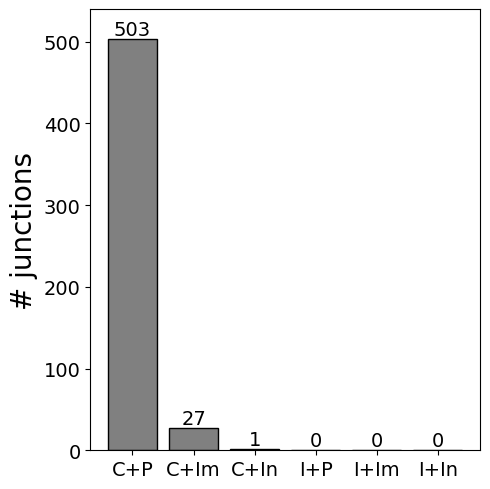

In [11]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

# C = correct site (within a few bp of AAGG|TAGC expected site)
# I = incorrect site (anywhere else in rDNA)
# P = precise initiation (at AAAA of transcript)
# Im = imprecise initiation (within a few bp of template end)
# In = internal initiation (any other initation site in template)
bars = ax.bar(np.arange(6),[C_P, C_Im, C_In, I_P, I_Im, I_In], fc='gray', ec='k')
ax.bar_label(bars, fontsize=14)
ax.set_ylim(0,540)
ax.set_xticks(np.arange(6))
ax.set_xticklabels(['C+P','C+Im','C+In','I+P','I+Im','I+In'])
ax.tick_params(labelsize=14)
ax.set_ylabel('# junctions', fontsize=20)

fig.tight_layout()
# fig.savefig('plots/A_3junctions.eps')

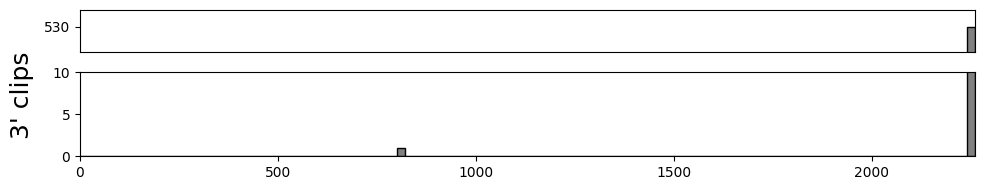

In [12]:
fig = plt.figure(figsize=(10,2))

gs = GridSpec(2, 1, height_ratios=[1,2])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax1.hist(initiationsites_nodup-840,bins=np.arange(0,2261,20), fc='gray', ec='k');
ax1.set_ylim(527,532)
ax1.set_xlim((0,2261))
ax1.set_xticks([])
ax1.set_yticks([530])

ax2.hist(initiationsites_nodup-840,bins=np.arange(0,2261,20), fc='gray', ec='k');
ax2.set_ylim(0,10)
ax2.set_xlim((0,2261))

fig.supylabel('3\' clips', fontsize=18)

fig.tight_layout()

# fig.savefig('plots/3truncations_A_split.eps')

In [13]:
print(Counter(IVS_list))

Counter({'GAAAATAGC': 501, 'GAAAGTAGC': 9, 'GAAAAAAGTAGC': 9, 'GAAAAAGTAGC': 7, 'GAAAATAGAAAAAAAAGTAGC': 1, 'GAAAATGGC': 1, 'GAAAATCGC': 1, 'GAAATAGC': 1})


Text(0.5, 0, '# junctions')

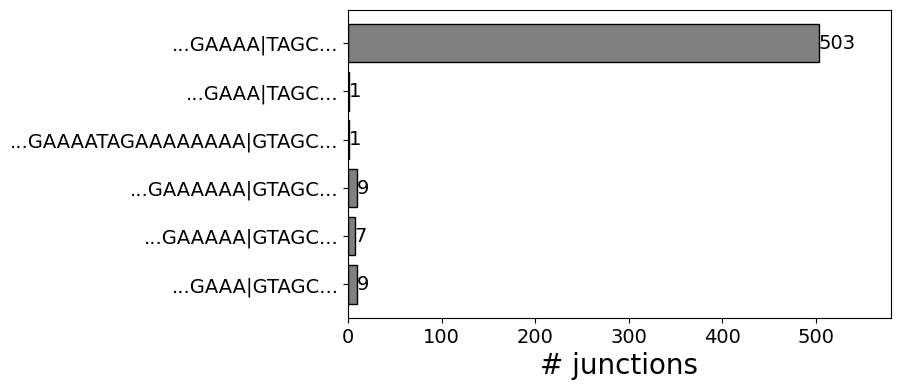

In [14]:
# manual assessment of categories
h = [Counter(IVS_list)['GAAAGTAGC'],
     Counter(IVS_list)['GAAAAAGTAGC'],
     Counter(IVS_list)['GAAAAAAGTAGC'],
     Counter(IVS_list)['GAAAATAGAAAAAAAAGTAGC'],
     Counter(IVS_list)['GAAATAGC'],
     Counter(IVS_list)['GAAAATAGC']+Counter(IVS_list)['GAAAATCGC']+Counter(IVS_list)['GAAAATGGC']]
labels = ['...GAAA|GTAGC...',
          '...GAAAAA|GTAGC...',
          '...GAAAAAA|GTAGC...',
          '...GAAAATAGAAAAAAAA|GTAGC...',
          '...GAAA|TAGC...',
          '...GAAAA|TAGC...']

fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)

bars = ax.barh(np.arange(len(h)),h, ec='k', fc='gray')
ax.bar_label(bars, fontsize=14)
ax.set_xlim(0,580)
# ax.set_yscale('log')

ax.set_yticks(np.arange(len(h)))
ax.set_yticklabels(labels)

ax.tick_params(labelsize=14)
ax.set_xlabel('# junctions', fontsize=20)

# assess 5' junctions

In [15]:
# create a separate df for 5' junctions

ids = []

for i, row in matepair_df.iterrows():
    junction = False
    for x in [1,2]:
        # is transgene full length? (i.e. does read cross junction)
        if (row['read%i_chr1' % x] == transgene_ref and row['read%i_start1' % x] < (flank_len-5) and row['read%i_end1' % x] > (flank_len+10)) or \
            (row['read%i_chr2' % x] == transgene_ref and row['read%i_start2' % x] < (flank_len-5) and row['read%i_end2' % x] > (flank_len+10)):
            junction = True
        if row['read%i_chr2' % x] == transgene_ref and row['read%i_chr1' % x] != transgene_ref:
            junction = True
    if junction:
        ids.append(i)
        
matepair_df_5pjunctions = matepair_df.loc[ids].reset_index()

In [16]:
truncations = np.array([], dtype=int)
truncations_nodup = np.array([], dtype=int)
upstream_rDNA = 28
offtarget_miscellaneous = []
FLP_list = []
FLI_list = []
TP_list = []
TI_list = []
FLA_list = []
TA_list = []
gapped_insertions = []
count = 0

for i, row in matepair_df_5pjunctions.iterrows():
    truncations_temp = []
    FLP_temp = False
    FLI_temp = False
    FLA_temp = False
    TP_temp = False
    TI_temp = False
    TA_temp = False
    for x in [1,2]:
        # candidate gapped transgenes or strange repair products
        if (row['read%i_chr1' % x] == transgene_ref and row['read%i_clipstatus1' % x] == '3clipped' and \
              row['read%i_start1' % x] < (flank_len-5) and row['read%i_end1' % x] > (flank_len+10)):
            FLA_temp = True
            truncations_temp.append(flank_len)
        # does it cross the 5' junction without duplication or deletion
        elif (row['read%i_chr1' % x] == transgene_ref and row['read%i_start1' % x] < (flank_len-upstream_rDNA-5) and row['read%i_end1' % x] > (flank_len+10)) or \
        (row['read%i_chr2' % x] == transgene_ref and row['read%i_start2' % x] < (flank_len-upstream_rDNA-5) and row['read%i_end2' % x] > (flank_len+10)):
            FLP_temp = True
            truncations_temp.append(flank_len)
        # does it cross the 5' junction but read stops before 28 bp
        elif (row['read%i_chr1' % x] == transgene_ref and row['read%i_clipstatus1' % x] == 'fully_mapped' and \
              row['read%i_start1' % x] < (flank_len-5) and row['read%i_end1' % x] > (flank_len+10)):
            FLA_temp = True
            truncations_temp.append(flank_len)
        # does it cross the 5' junction but has duplication or deletion
        elif (row['read%i_chr1' % x] == transgene_ref and row['read%i_start1' % x] < (flank_len-5) and row['read%i_end1' % x] > (flank_len+10)) or \
        (row['read%i_chr2' % x] == transgene_ref and row['read%i_start2' % x] < (flank_len-5) and row['read%i_end2' % x] > (flank_len+10)):
            FLI_temp = True
            truncations_temp.append(flank_len)
            
        # is it truncated
        elif (row['read%i_chr2' % x] == transgene_ref and row['read%i_clipstatus2' % x] == '5clipped' and row['read%i_start2' % x] > flank_len):
            # does it join near the nick site
            if (row['read%i_chr1' % x] == transgene_ref and np.abs(row['read%i_end1' % x]-flank_len)<4) or \
            (row['read%i_chr1' % x] == 'NR_145819.1' and np.abs(row['read%i_end1' % x]-11698)<4):
                TP_temp = True
                truncations_temp.append(row['read%i_start2' % x])
                # print(row)
            # or is it alignment with a gap
            elif row['read%i_chr1' % x] == transgene_ref and row['read%i_end1' % x] > flank_len:
                gapped_insertions.append(i)
            # or somewhere else in rDNA
            elif is_rDNA(row['read%i_chr1' % x], row['read%i_end1' % x]):
                TI_temp = True
                # print(row)
                truncations_temp.append(row['read%i_start2' % x])
            elif row['read%i_loc2' % x] <= 10:
                TA_temp = True
            else:
                seq = row['read%i_seq' % x][:row['read%i_loc2' % x]]
                dist = int(len(seq)/10)+1
                match = get_bestmatch(find_near_matches(seq, rDNA_45S, max_l_dist=dist))
                if match and np.abs(match.end-11698)<4:
                    TP_temp = True
                    truncations_temp.append(row['read%i_start2' % x])
                elif match:
                    TI_temp = True
                    truncations_temp.append(row['read%i_start2' % x])
                else:
                    seq = str(Seq(row['read%i_seq' % x][:row['read%i_loc2' % x]]).reverse_complement())
                    match = get_bestmatch(find_near_matches(seq, rDNA_45S, max_l_dist=dist))
                    if match:
                        TI_temp = True
                        truncations_temp.append(row['read%i_start2' % x])
                    else:
                        TA_temp = True

    if FLP_temp and FLI_temp:
        FLI_temp = False
    if FLP_temp and FLA_temp:
        FLA_temp = False
    if FLA_temp and FLI_temp:
        FLA_temp = False
    if TP_temp and TI_temp:
        TI_temp = False
    if TI_temp and FLI_temp:
        TI_temp = False
    if TP_temp and TA_temp:
        TA_temp = False
    if TA_temp and TI_temp:
        TA_temp = False
        
    if FLI_temp:
        FLI_list.append(i)
    if FLP_temp:
        FLP_list.append(i)
    if FLA_temp:
        FLA_list.append(i)
    if TI_temp:
        TI_list.append(i)
    if TP_temp:
        TP_list.append(i)
    if TA_temp:
        TA_list.append(i)
        

    truncations = np.hstack([truncations,truncations_temp])
    truncations_nodup = np.hstack([truncations_nodup,np.unique(truncations_temp)])

# print(FL_P, FL_I, T_P, T_I)
truncations = truncations[truncations>(flank_len-1)]
truncations_nodup = truncations_nodup[truncations_nodup>(flank_len-1)]
# print(len(truncations_nodup))

In [17]:
# make sure no problematic or doubly labeled junctions

categories = np.hstack([FLA_list, FLI_list, FLP_list, TA_list, TI_list, TP_list, gapped_insertions])

duplicates = []

for i in categories:
    if np.count_nonzero(categories==i)>1:
        duplicates.append(i)
        
duplicates = np.unique(duplicates)

FLA_list = np.unique([x for x in FLA_list if x not in duplicates])
FLI_list = np.unique([x for x in FLI_list if x not in duplicates])
FLP_list = np.unique([x for x in FLP_list if x not in duplicates])

TA_list = np.unique([x for x in TA_list if x not in duplicates])
TI_list = np.unique([x for x in TI_list if x not in duplicates])
TP_list = np.unique([x for x in TP_list if x not in duplicates])

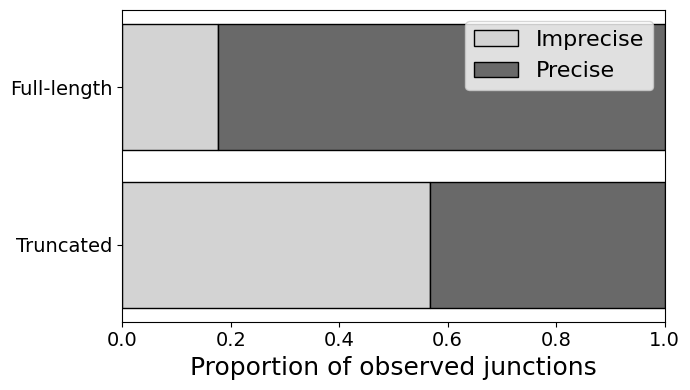

In [18]:
fig = plt.figure(figsize=(7,4))

FL = len(FLI_list) + len(FLP_list)
FL_I = len(FLI_list)/FL
FL_P = len(FLP_list)/FL
FL_A = len(FLA_list)/FL

T = len(TI_list) + len(TP_list)
T_I = len(TI_list)/T
T_P = len(TP_list)/T
T_A = len(TA_list)/T

ax = fig.add_subplot(111)
a = ax.barh(y=[1,1,0,0],width=[FL_I, FL_P, T_I, T_P],
        left=[0,FL_I,0,T_I], ec='k', color=['lightgray','dimgray',])
ax.set_yticks([0,1])
ax.set_yticklabels(['Truncated','Full-length'])
ax.tick_params(labelsize=14)
ax.set_xlabel('Proportion of observed junctions', fontsize=18)
ax.set_xlim(0,1)

ax.legend(a,['Imprecise','Precise'], fontsize=16)
fig.tight_layout()

# fig.savefig('plots/A_5junctions_percentbars_updated.eps')
# fig.savefig('plots/Fig3D_updated.eps')

# fig.savefig('plots/A_5junctions_percentbars.png')

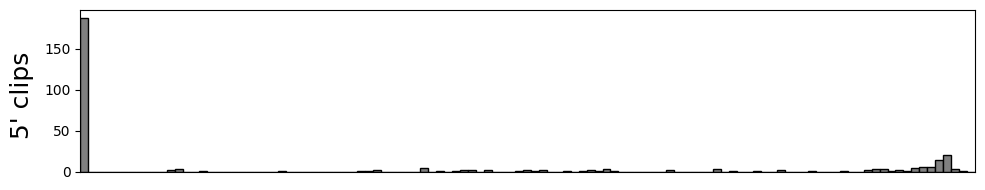

In [19]:
fig = plt.figure(figsize=(10,2))

ax = fig.add_subplot(111)
# ax2 = fig.add_subplot(gs[1])

ax.hist(truncations_nodup-flank_len,bins=np.arange(0,2261,20), fc='gray', ec='k');
# ax.set_ylim(182,192)
ax.set_xlim((0,2261))
ax.set_xticks([])
# ax.set_yticks([190])

# ax2.hist(truncations_nodup-flank_len,bins=np.arange(0,2261,20), fc='gray', ec='k');
# ax2.set_ylim(0,20)
# ax2.set_xlim((0,2261))

fig.supylabel('5\' clips', fontsize=18)
fig.tight_layout()


# fig.savefig('plots/5truncations_A_split.eps')

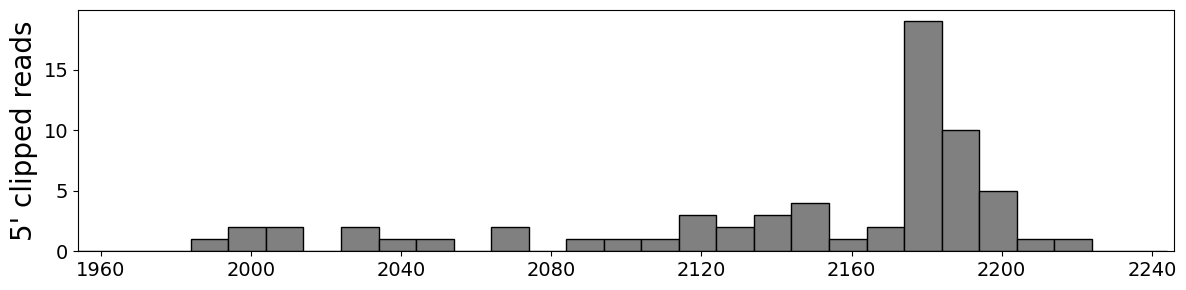

In [20]:
fig = plt.figure(figsize=(12,3))

junctions = truncations_nodup-flank_len
UTR_len = 292
bins = np.arange(transgene_len-UTR_len,transgene_len,10)

ax = fig.add_subplot(111)
ax.hist(junctions[junctions>(transgene_len-UTR_len)], bins=bins, fc='gray', ec='k')

ax.set_xlim((transgene_len-UTR_len),transgene_len)
ax.set_ylabel('5\' clipped reads', fontsize=20)
# ax.set_xlabel('Transgene position', fontsize=24)
ax.tick_params(labelsize=10)

ax.set_xticks(np.arange(1960,2245,40))
ax.tick_params(labelsize=14)
fig.tight_layout()

# fig.savefig('plots/UTR_truncations.png', dpi=600)
# fig.savefig('plots/UTR_truncations_A.eps')

# identify "gapped" insertions

In [21]:
def draw_connection(ax, start, end, tg_len=840):
    start -= tg_len
    end -= tg_len
    w = end-start
    xy = (start+w/2,0)
    ax.add_patch(patches.Arc(xy, width=w, height=w/1000))

In [22]:
coords = []
for i, row in matepair_df_5pjunctions.iterrows():
    for x in [1,2]:
        if row['read%i_chr1' % x] == transgene_ref and row['read%i_clipstatus1' % x] == '3clipped' and row['read%i_end1' % x] > flank_len+2 and \
            row['read%i_chr2' % x] == transgene_ref and row['read%i_clipstatus2' % x] == '5clipped':
            coords.append((row['read%i_end1' % x], row['read%i_start2' % x]))

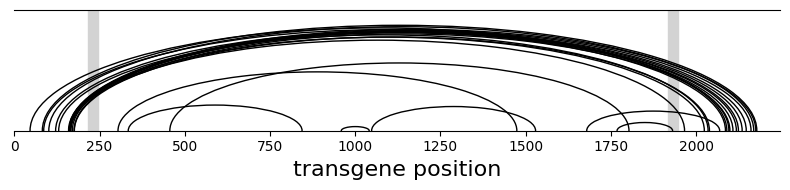

In [23]:
fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax.axes.get_yaxis().set_visible(False)
ax.spines['left'].set_visible(False)
# ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlim(0,transgene_len)
ax.set_ylim(0,1.2)
ax.set_xlabel('transgene position', fontsize=16)

ax.axvspan(LacO_sites[0], LacO_sites[0]+len(LacO_seq), color='lightgray')
ax.axvspan(LacO_sites[1], LacO_sites[1]+len(LacO_seq), color='lightgray')


for coord in coords:
    draw_connection(ax,coord[0],coord[1])


fig.tight_layout()
# fig.savefig('A_gappedinsertions.eps')

# identify template jumps

In [24]:
# look for template jumps
candidates = []

for i, row in matepair_df_5pjunctions.iterrows():
    for x in [1,2]:
        if row['read%i_chr2' % x] == transgene_ref and row['read%i_clipstatus2' % x] == '5clipped' and \
        row['read%i_chr1' % x] != '-1' and not is_rDNA(row['read%i_chr1' % x], row['read%i_start1' % x]):
            candidates.append(i)

In [25]:
np.unique(candidates)

array([111, 224, 267, 323, 407])

In [26]:
# example of manual review of candidate template jumps
matepair_df_5pjunctions.loc[224]

index                                                             1324
read_ID                        A00887:430:H7GFYDSX3:4:2116:28691:31203
read1_orientation                                                    F
read2_orientation                                                    R
read1_seq            CTCGCTTCGGCAGCACATATACTAAAATTGGAACGATACAGAGAAG...
read2_seq            GACACGGATACCCTTACCGGACTTGTCATGATCTCCCAGACTTGTC...
read1_chr1                                                       chr19
read1_start1                                                    984193
read1_end1                                                      984298
read1_loc1                                                           0
read1_mapq1                                                          0
read1_clipstatus1                                             3clipped
read1_chr2                      rDNA-flanked_TriCasA5_CBhBsi_GFP_GeFo3
read1_start2                                                       812
read1_

In [27]:
matepair_df_5pjunctions.loc[224]['read1_seq']

'CTCGCTTCGGCAGCACATATACTAAAATTGGAACGATACAGAGAAGATTAGCATGGCCCCTGCGCAAGGATGACACGCAAATTCGTGAAGCGTTCCATATTTTTGGCGGGAGTAACTATGACTCTCTTAAGGAGTCATAGAGCCAGAACCT'

In [28]:
# maps to U6 snRNA -- validated with NCBI blast
matepair_df_5pjunctions.loc[224]['read1_seq'][:104]

'CTCGCTTCGGCAGCACATATACTAAAATTGGAACGATACAGAGAAGATTAGCATGGCCCCTGCGCAAGGATGACACGCAAATTCGTGAAGCGTTCCATATTTTT'

In [29]:
# maps to transgene template
matepair_df_5pjunctions.loc[224]['read1_seq'][104:]

'GGCGGGAGTAACTATGACTCTCTTAAGGAGTCATAGAGCCAGAACCT'

# off-target, uncertain insetions

In [30]:
matepair_df[matepair_df['read_ID'].isin(off_target)]

,read_ID,read1_orientation,read2_orientation,read1_seq,read2_seq,read1_chr1,read1_start1,read1_end1,read1_loc1,read1_mapq1,...,read2_loc1,read2_mapq1,read2_clipstatus1,read2_chr2,read2_start2,read2_end2,read2_loc2,read2_mapq2,read2_clipstatus2,mate_orientation
985,A00887:430:H7GFYDSX3:4:1551:31394:23766,R,F,CAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCC...,CAGAAGAACGGCATCAAGGTGAACTTCAAGATCCGCCACAACATCG...,rDNA-flanked_TriCasA5_CBhBsi_GFP_GeFo3,2427,2508,0,60,...,0,60,3clipped,-1,-1,-1,-1,-1,-1,"R,F"


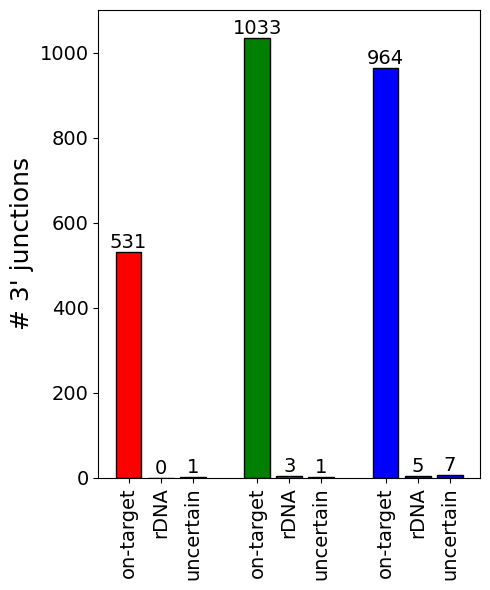

In [31]:
fig = plt.figure(figsize=(5,6))
ax = fig.add_subplot(111)

A_target = [531,0,1]
D_target = [1033,3,1]
E_target = [964,5,7]

x = [0,1,2,4,5,6,8,9,10]
bars = ax.bar(x, A_target+D_target+E_target, color=['r']*3+['g']*3+['b']*3, ec='k')
ax.bar_label(bars, fontsize=14)
ax.set_ylabel('# 3\' junctions', fontsize=18)
ax.tick_params(labelsize=14)
ax.set_ylim(0,1100)

ax.set_xticks(x)
ax.set_xticklabels(['on-target','rDNA','uncertain']*3, rotation=90)

fig.tight_layout()
# fig.savefig('plots/offtarget_reads.eps')